<a href="https://colab.research.google.com/github/inesbsilveira/estufas/blob/main/test_20230930_IS_MC_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports, parameters and variables**

In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 72.1 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image
from fastai.vision.all import *
from sklearn.metrics import classification_report, roc_auc_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tifffile as tiff
import matplotlib.image as mpimg
from rasterio.windows import from_bounds
import ee
import scipy

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=pnG4JbRSwOyFYeZpDB4KgCk9UPm4BMIopQwe8ToGW4g&tc=fSlFJS9SS67-DpVeFDKQn0FMTn2bUdPYoNxyupan4qk&cc=7ssw520fd4RnpnnxxHwZgGCwPaVoy3yxpBamnKPKDpU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXkWlIfwTA9oq_0lRFfpr4TW0Ftf9rjz-O2jtjnwnv-X7R46E7s15Hg

Successfully saved authorization token.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
user='I' # escolher 'M' ou 'I'
N_epochs=30
target_names = ['not greenhouse', 'greenhouse']
Nrows,Ncols = 20, 8 # número de blocos a usar 20*8=160
model_name = 'model_30epochs.pkl'
new_model_name = 'model_30epochs.pkl'
train_model = True

In [6]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/Estufas'

path=Path(directory)
image_folder_name = "images"
label_folder_name = "labels"
predicted_folder_name = "predicted"
image_folder = os.path.join(directory, image_folder_name)
os.makedirs(image_folder, exist_ok=True)
label_folder = os.path.join(directory, label_folder_name)
os.makedirs(label_folder, exist_ok=True)
predicted_folder = os.path.join(directory, predicted_folder_name)
os.makedirs(predicted_folder, exist_ok=True)

# **Functions**

## Retrieve Images from Google Earth Engine

In [7]:
# Function to extract images from google earth engine

"""
Inputs:
- extent = (lonmin, lonmax, latmin, latmax)
- start_date and end_date = 'YYY-MM-DD'
- band_name = 'B2', 'B3', 'B4' or 'B8'
- folder_name = 'folder_name' is where the tiff file is stored
Output: tiff file saved in folder_name
"""

def gee_images (extent, start_date, end_date, band_name, folder_name):

    # Define the extent
    lonmin, lonmax, latmin, latmax = extent

    region = ee.Geometry.Polygon(
        [[
            [lonmin, latmin],
            [lonmax, latmin],
            [lonmax, latmax],
            [lonmin, latmax]
        ]])

    # Define the Sentinel-2 image collection and filter it by date and region
    sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
        .filterBounds(region) \
        .filterDate(start_date, end_date)  # Change the date range as needed

    # Define a function to mask clouds using the QA60 band
    def maskClouds(image):
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11
        qa60 = image.select(['QA60'])
        cloudMask = qa60.bitwiseAnd(cloudBitMask).eq(0) \
            .And(qa60.bitwiseAnd(cirrusBitMask).eq(0))
        return image.updateMask(cloudMask)

    # Map the maskClouds function over the image collection
    sentinel2 = sentinel2.map(maskClouds)

    # Define a function to add a band containing the date of the image
    def addDate(image):
        return image.addBands(image.metadata('system:time_start'))

    # Map the addDate function over the image collection
    sentinel2 = sentinel2.map(addDate)

    # Export each image to Google Drive
    image_list = sentinel2.toList(sentinel2.size())
    for i in range(0, sentinel2.size().getInfo()):
        image = ee.Image(image_list.get(i))
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        task = ee.batch.Export.image.toDrive(
            image=image.select([band_name]),
            description='Sentinel2_' + band_name + '_' + date.getInfo(),
            folder= folder_name,
            region=region,
            scale=10  # Change the scale as needed
        )
        task.start()

## Clip and saturate tiff files

In [8]:
# clip tiff file by extent (xmin, ymin, xmax, ymax)
def clip_tiff_by_extent(input_file, output_file, extent):
    # Open the input GeoTIFF file
    with rasterio.open(input_file) as src:
        # Create a window representing the desired extent
        window = from_bounds(*extent, transform=src.transform)

        # Read the data within the window
        clipped_data = src.read(window=window)

        # Update the transform to reflect the new window
        new_transform = src.window_transform(window)

        # Create a new GeoTIFF file with the clipped data
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=window.width,
            height=window.height,
            count=src.count,
            dtype=clipped_data.dtype,
            crs=src.crs,
            transform=new_transform
        ) as dst:
            dst.write(clipped_data)

In [9]:
#saturate array considering bigmin and bigmax values. output is an array
def recalculate_array(arr, bigmin, bigmax):
    # Saturate values below bigmin to bigmin and above bigmax to bigmax
    saturated_arr = np.clip(arr, bigmin, bigmax)
    return saturated_arr

In [10]:
#Calculate bigmin and bigmax and saturated tif file accordingly
def satu_tiff(input_file, output_file):
    with rasterio.open(input_file) as src:
        # Get the number of bands in the input GeoTIFF
        num_bands = src.count

        # Initialize an empty list to store the saturated bands
        saturated_bands = []

        for band_idx in range(1, num_bands + 1):
            # Read the band into a NumPy array
            band = src.read(band_idx)

            # Calculate bigmin and bigmax for the current band based on percentiles or other criteria
            bigmin = np.percentile(band, 1)  # 1st percentile
            bigmax = np.percentile(band, 99)  # 99th percentile

            # Recalculate the array values for the current band
            saturated_band = recalculate_array(band, bigmin, bigmax)

            # Append the saturated band to the list
            saturated_bands.append(saturated_band)

        # Create a new GeoTIFF file with the saturated bands
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=src.width,
            height=src.height,
            count=num_bands,
            dtype=saturated_bands[0].dtype,
            crs=src.crs,
            transform=src.transform
        ) as dst:
            for band_idx, band in enumerate(saturated_bands, start=1):
                dst.write(band, band_idx)

## Calculate indexes - NDVI, RPGI, albedo

In [11]:
# Calculate NDVI using the Red band and NIR band. Output is a 1 band tiff file
def calculate_ndvi(red_file, nir_file, output_file):
    # Open the Red, Green, NIR, and Blue band GeoTIFF files
    with rasterio.open(red_file) as red_src, rasterio.open(nir_file) as nir_src:

        # Read the Red and NIR bands
        red_band = red_src.read(1)
        nir_band = nir_src.read(1)

        # Calculate NDVI
        with np.errstate(divide='ignore', invalid='ignore'):
            # Ignore division by zero and invalid (e.g., NaN) results
            ndvi = np.where(
                (nir_band + red_band) == 0,
                0.0,  # Set NDVI to 0 where the denominator is 0
                (nir_band - red_band) / (nir_band + red_band)
            )

        # Create a new GeoTIFF file with the NDVI band
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=red_src.width,
            height=red_src.height,
            count=1,
            dtype=ndvi.dtype,
            crs=red_src.crs,
            transform=red_src.transform
        ) as dst:
            dst.write(ndvi, 1)

In [12]:
# Calculate RPGI using Blue band, green band and NIR band. Output is a 1 band tiff file
def calculate_rpgi(blue_file, green_file, nir_file, output_file):
    # Open the Red, Green, NIR, and Blue band GeoTIFF files
    with rasterio.open(blue_file) as blue_src, rasterio.open(nir_file) as nir_src, rasterio.open(green_file) as green_src:

        # Read the Blue, Green, and NIR bands
        blue_band = blue_src.read(1)
        green_band = green_src.read(1)
        nir_band = nir_src.read(1)

        # Calculate RPGI
        with np.errstate(divide='ignore', invalid='ignore'):
            rpgi = (blue_band) / (1 - np.mean(blue_band + green_band + nir_band))

        # Create a new GeoTIFF file with the NDVI band
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=blue_src.width,
            height=blue_src.height,
            count=1,
            dtype=rpgi.dtype,
            crs=blue_src.crs,
            transform=blue_src.transform
        ) as dst:
            dst.write(rpgi, 1)

In [13]:
# Calculate albedo using blue band, green band and red band. the output is a 3 bands tiff file
def calculate_albedo(blue_file, green_file, red_file, output_file):
    # Open the Red, Green, NIR, and Blue band GeoTIFF files
    with rasterio.open(blue_file) as blue_src, rasterio.open(red_file) as red_src, rasterio.open(green_file) as green_src:

        # Read the Red, Green and Blue bands
        blue_band = blue_src.read(1)
        green_band = green_src.read(1)
        red_band = red_src.read(1)

        # Calculate albedo
        albedo = blue_band + green_band + red_band

        # Create a new GeoTIFF file with the NDVI band
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=blue_src.width,
            height=blue_src.height,
            count=1,
            dtype=albedo.dtype,
            crs=blue_src.crs,
            transform=blue_src.transform
        ) as dst:
            dst.write(albedo, 1)

In [14]:
# Put together all the indexes. the output is a tiff file with 3 bands
def calculate_ndvi_rpgi_albedo(ndvi_file, rpgi_file, albedo_file, output_file):
    # Open the Red, Green, NIR, and Blue band GeoTIFF files
    with rasterio.open(ndvi_file) as ndvi_src, rasterio.open(rpgi_file) as rpgi_src, rasterio.open(albedo_file) as albedo_src:
        # Read the NDVI, RPGI, and Albedo bands
        ndvi_band = ndvi_src.read(1)
        rpgi_band = rpgi_src.read(1)
        albedo_band = albedo_src.read(1)

        # Create a new GeoTIFF file with multiple bands
        with rasterio.open(
            output_file,
            'w',
            driver='GTiff',
            width=ndvi_src.width,
            height=ndvi_src.height,
            count=3,  # Set the count to the number of input bands (NDVI, RPGI, Albedo)
            dtype=ndvi_band.dtype,  # Use the data type of the input bands
            crs=ndvi_src.crs,
            transform=ndvi_src.transform
        ) as dst:
            # Write each band to the output GeoTIFF
            dst.write(ndvi_band, 1)
            dst.write(rpgi_band, 2)
            dst.write(albedo_band, 3)

## TIFF files

### Displat tiff unique values

In [15]:
# Display unique values and their datatype in a tif file. output is a list of unique values, datatype and a numpy array
def display_unique_values_tiff_file (input_file):
  # Open the TIFF file
  with rasterio.open(input_file, 'r') as src:
      # Read the data as a NumPy array
      tiff_array = src.read(1)  # Assuming it's a single-band TIFF

      # Find unique values in the NumPy array
      unique_values = np.unique(tiff_array)

      # Get the data type of the TIFF file
      data_type = src.dtypes[0]

  # Display the data type
  print(f"Data Type: {data_type}")

  # Display the unique values
  print("Unique Values:")
  for value in unique_values:
      print(value)

  # Print the data in the NumPy array
  print(tiff_array)

### Convert NODATA values

In [17]:
# Replace NODATA values with 0 in a tiff file and convert the datatype. this function requires the the value assigned to nodata values
def convert_nodata_values (nodata_value, input_file,output_file):
  # Open the input TIFF file
  with rasterio.open(input_file, 'r') as src:
      # Read the data as a NumPy array
      data = src.read(1)

      # Replace NoData values with 0
      data[data == nodata_value] = 0

      # Create a new TIFF file for writing
      with rasterio.open(
          output_file,
          'w',
          driver='GTiff',
          width=src.width,
          height=src.height,
          count=1,
          dtype=rasterio.uint8,  # Adjust data type as needed
          crs=src.crs,
          transform=src.transform,
      ) as dst:
          # Write the modified data to the new TIFF file
          dst.write(data, 1)

  print(f"NoData values converted to 0")


### Display

In [18]:
# Display a TIFF file. input should be a tiff file
def display_tiff_file (input_file):
  # Load and display the TIFF image
  img = mpimg.imread(input_file)
  plt.imshow(img, cmap='gray')  # Use 'gray' colormap for binary images
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()


## PNG images

### check size, len, shape and datatype of numpy array

In [108]:
def check_size_len_datatype_array (input_file):
  # Create a sample NumPy array
  arr = np.array(Image.open(input_file))
  # Check the size
  array_size = arr.size
  print(f"Size of the array: {array_size}")
  # Check the length (for 2D arrays, this is the number of rows)
  array_length = len(arr)
  print(f"Length of the array: {array_length}")
  # Shape
  array_shape = arr.shape
  print("Shape:", array_shape)
  # Check the data type
  array_dtype = arr.dtype
  print(f"Data type of the array: {array_dtype}")

### Convert pixel values

In [83]:
# function to replace a pixel value in a PNG image. the output is another PNG with the changes pixelvalues
def convert_values_png (input_file, output_file, pixelvalue):
  image = Image.open(input_file)
  # Convert the image to grayscale (optional, depending on your input)
  image = image.convert('L')
  # Create a new image to store the modified pixels
  new_image = Image.new('L', image.size)
  # Iterate over the pixels and replace 255 with 1, leaving other values as 0
  for x in range(image.width):
      for y in range(image.height):
          pixel_value = image.getpixel((x, y))
          if pixel_value == pixelvalue:
              new_image.putpixel((x, y), 1)
          else:
              new_image.putpixel((x, y), 0)
  # Save the modified image
  new_image.save(output_file)
  print("Image processing complete. Saved as", output_file)

### Display unique values and datatype

In [16]:
# Display unique values and their datatype in a PNG image. output is a list of unique values, datatype and a numpy array
def display_unique_values_and_datatype(input_file):
    # Open the PNG image
    img = Image.open(input_file)

    # Convert the image to a NumPy array
    png_array = np.array(img)

    # Find unique values in the NumPy array
    unique_values = np.unique(png_array)

    # Get the data type of the PNG image
    data_type = png_array.dtype

    # Display the data type
    print(f"Data Type: {data_type}")

    # Display the unique values
    print("Unique Values:")
    for value in unique_values:
        print(value)

    # Print the data in the NumPy array
    print(png_array)

### Display

In [ ]:
def display_png (input_file):
  # Open the PNG image
  image = Image.open(input_file)

  # Display the image using Matplotlib
  plt.imshow(image)
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()

## Clip and rescale tiff files

In [19]:
# Function to clip and rescale tif files and save png images in a folder
# Input files are tiff files with 1 or 3 bands, output_folder is the folder where the png images are going to be stored. Nrows and Ncols are defined above
def clip_raster_and_rescale(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols
        Nbands = src.count  # Get the number of bands in the input file

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                if Nbands == 1:
                    clipped_data = src.read(window=window)
                    clipped_meta = src.meta.copy()
                    clipped_meta.update({
                        'height': window.height,
                        'width': window.width,
                        'transform': src.window_transform(window)
                })
                    output_file = os.path.join(output_folder, f'image_{i}_{j}_mask.png')
                    with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                        dst.write(clipped_data)
                elif Nbands == 3:
                    clipped_data_1 = rescale_to_8bits(src.read(1, window=window))
                    clipped_data_2 = rescale_to_8bits(src.read(2, window=window))
                    clipped_data_3 = rescale_to_8bits(src.read(3, window=window))
                    rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)
                    image = Image.fromarray(rgb_image, mode='RGB')
                    output_file = os.path.join(output_folder, f'image_{i}_{j}.png')
                    image.save(output_file)
                else:
                    raise ValueError("Input file must have 1 or 3 bands.")

        return height, width

In [20]:
# Function to rescale an RGB tif to 8 bits
def rescale_to_8bits(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    arr_std = arr_std.astype(np.uint8)
    return arr_std

In [21]:
# Calculate the values for bigmin and bigmax for a 3 bands image. These values will be used to rescale the image to 8bits, considering the min and max values
"""def calculate_bigmin_bigmax (input_file):
  # Load the TIFF image
  image = tiff.imread(input_file)

  # Calculate bigmin and bigmax based on percentiles or other criteria
  bigmin = np.percentile(image, 1)  # 1st percentile
  bigmax = np.percentile(image, 99)  # 99th percentile
  #print("bigmin:", bigmin)
  #print("bigmax:", bigmax)

  return bigmin, bigmax"""

'def calculate_bigmin_bigmax (input_file):\n  # Load the TIFF image\n  image = tiff.imread(input_file)\n\n  # Calculate bigmin and bigmax based on percentiles or other criteria\n  bigmin = np.percentile(image, 1)  # 1st percentile\n  bigmax = np.percentile(image, 99)  # 99th percentile\n  #print("bigmin:", bigmin)\n  #print("bigmax:", bigmax)\n\n  return bigmin, bigmax'

In [22]:
# Function to rescale an RGB tif to 8 bits
"""def rescale_to_8bits(arr, bigmin, bigmax):
  # Clip values to the specified range [bigmin, bigmax]
  arr = np.clip(arr, bigmin, bigmax)
  # Scale the values to the 0-255 range
  arr_scaled = (arr - bigmin) / (bigmax - bigmin) * 255
  # Convert to 8-bit unsigned integer
  arr_std = arr_scaled.astype(np.uint8)

  return arr_std"""

'def rescale_to_8bits(arr, bigmin, bigmax):\n  # Clip values to the specified range [bigmin, bigmax]\n  arr = np.clip(arr, bigmin, bigmax)\n  # Scale the values to the 0-255 range\n  arr_scaled = (arr - bigmin) / (bigmax - bigmin) * 255\n  # Convert to 8-bit unsigned integer\n  arr_std = arr_scaled.astype(np.uint8)\n\n  return arr_std'

In [23]:
# Define the function to extract the row and column number from image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [24]:
# Get the clipped blocks from a image_folder
def get_items(image_folder):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    #return mask_folder / f'{image_file.stem}_mask.png'
    return os.path.join(label_folder, f'{image_file.stem}_mask.png')

In [25]:
# Display sample of predictions
def sample_preds (preds, sample_idx):
  # Display sample predictions
  #sample_idx = 0
  sample_image_path = list(test_dl.items)[sample_idx]
  sample_image = PILImage.create(sample_image_path)
  sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

  sample_image.show()
  TensorImage(sample_pred).show(cmap='tab20')

## Save and merge blocks

In [26]:
# Create predicted mask for each of the blocks
# Save the predicted mask images (png) according to their row and column number
def create_predited_mask(image_folder,learn,predicted_folder):
  test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
  preds = learn.get_preds(dl=test_dl)[0]
  for idx, pred in enumerate(preds):
      # Get the row and column number from the test image file name
      sample_image_path = list(test_dl.items)[idx]
      row, column = get_row_column_from_filename(sample_image_path)

      # Create a folder for each row if it doesn't exist
      folder = os.path.join(predicted_folder)
      os.makedirs(folder, exist_ok=True)

      # Create a filename for the predicted mask image
      predicted_filename = f'image_{row}_{column}_predicted.png'
      predicted_filepath = os.path.join(folder, predicted_filename)

      # Convert the predicted mask to a PIL Image
      sample_pred = pred.argmax(dim=0).numpy()
      predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

      # Save the predicted mask image
      predicted_image.save(predicted_filepath)

In [27]:
# Count the number of bands in a PNG image
def count_bands(image_file):
    with Image.open(image_file) as img:
        return img.mode

In [28]:
# Function to put together the clipped blocks from images, labels and predicted folder. output is a PNG image
def merge_blocks(input_folder, folder_name, output_filename, Nrows, Ncols, width, height):
  if folder_name == 'labels':
    # Count the number of bands in the first image to determine the mode
    sample_image = os.path.join(input_folder, f'image_0_0_mask.png')
    Nbands = len(count_bands(sample_image))
  elif folder_name == 'predicted':
    sample_image = os.path.join(input_folder, f'image_0_0_predicted.png')
    Nbands = len(count_bands(sample_image))
  elif folder_name == 'images':
    sample_image = os.path.join(input_folder, f'image_0_0.png')
    Nbands = len(count_bands(sample_image))

  rows, columns = Nrows, Ncols  # Number of rows and columns in the grid
  merged_width = width * columns
  merged_height = height * rows

  if Nbands == 1:
      merged_image = Image.new('L', (merged_width, merged_height))  # Use 'L' mode for grayscale images
  elif Nbands == 3:
      merged_image = Image.new('RGB', (merged_width, merged_height))
  else:
      raise ValueError("Input must have 1 or 3 bands.")

  # Loop through each row and column to merge the images
  for i in range(rows):
      for j in range(columns):
          if folder_name == 'labels':
              # Load the label mask image and paste it as is (no conversion needed)
              label_file = os.path.join(input_folder, f'image_{i}_{j}_mask.png')
              label_image = Image.open(label_file)
              merged_image.paste(label_image, (j * width, i * height))
          elif folder_name == 'predicted':
              # Load the predicted mask image
              predicted_file = os.path.join(input_folder, f'image_{i}_{j}_predicted.png')
              #predicted_file = os.path.join(input_folder, f'image_{i}_{j}.png')
              predicted_image = Image.open(predicted_file)
              merged_image.paste(predicted_image, (j * width, i * height))
          elif folder_name == 'images':
              # Load the predicted mask image
              image_file = os.path.join(input_folder, f'image_{i}_{j}.png')
              image = Image.open(image_file)
              merged_image.paste(image, (j * width, i * height))

  # Save the merged image
  merged_output_file = os.path.join(directory, output_filename)
  merged_image.save(merged_output_file)

## Display errors and examples

In [29]:
# Calculate pixel-wise errors and store them in a dictionary
# uses the test dataset, and displays the top 5 images where the error is higher (image and respective label, predicted label, and difference between them)
def pixel_wise_errors (test_file_names, label_folder, predicted_folder, image_folder):
  errors = {}
  for file_name in test_file_names:
      # Load the ground truth mask for the sample from the "labels" folder
      row, column = get_row_column_from_filename(file_name)
      mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
      true_mask = np.array(Image.open(mask_file))

      # Load the predicted mask for the sample from the "predicted" folder
      predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
      pred_mask = np.array(Image.open(predicted_file))

      # Calculate the pixel-wise error between the true mask and predicted mask
      error = np.sum(np.abs(true_mask - pred_mask))
      errors[file_name] = error

  # Sort the blocks by error in descending order
  sorted_errors = {k: v for k, v in sorted(errors.items(), key=lambda item: item[1], reverse=True)}

  # Get the file names of the blocks with the highest errors
  top_5_blocks = list(sorted_errors.keys())[:5]

  # Display the top 5 blocks with the highest errors
  num_columns = 4

  fig, axes = plt.subplots(len(top_5_blocks), num_columns, figsize=(20, 5 * len(top_5_blocks)))

  for i, file_name in enumerate(top_5_blocks):
      sample_image_path = os.path.join(image_folder, file_name)
      sample_image = PILImage.create(sample_image_path)

      # Load the ground truth mask for the sample from the "labels1" folder
      row, column = get_row_column_from_filename(file_name)
      mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
      true_mask = np.array(Image.open(mask_file))

      # Load the predicted mask for the sample from the "predicted" folder
      predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
      pred_mask = np.array(Image.open(predicted_file))

      # Display the satellite aggregate image with file name as title
      axes[i, 0].imshow(sample_image)
      # Add the line below to set the title
      axes[i, 0].set_title(str(file_name) + " (Error: " + str(errors[file_name]) + ")")
      #axes[i, 0].set_title(file_name + " (Error: " + str(errors[file_name]) + ")")
      axes[i, 0].axis('off')

      # Display the true mask
      axes[i, 1].imshow(true_mask, cmap='gray')
      axes[i, 1].set_title('True Mask')
      axes[i, 1].axis('off')

      # Display the predicted mask
      axes[i, 2].imshow(pred_mask, cmap='tab20')
      axes[i, 2].set_title('Predicted Mask')
      axes[i, 2].axis('off')

      # Display the difference between true and predicted masks
      difference_mask = true_mask - pred_mask
      axes[i, 3].imshow(difference_mask, cmap='coolwarm', vmin=-1, vmax=1)
      axes[i, 3].set_title('Difference')
      axes[i, 3].axis('off')

  plt.tight_layout()
  plt.show()

In [30]:
# Displays 6 examples of images and their respective labels and predicted labels
def display_images(directory, image_folder, label_folder, predicted_folder, preds):
    preds = learn.get_preds(dl=dls.valid)[0]
    # Display sample predictions using file names of test_set
    sample_files = [Path(file_path).name for file_path in test_file_names]

    # Slice the sample_files list to include only the first 6 samples
    sample_files = sample_files[:6]

    # Define the number of columns (including both true and predicted masks)
    num_columns = 3

    fig, axes = plt.subplots(len(sample_files), num_columns, figsize=(15, 5 * len(sample_files)))

    for i, file_name in enumerate(sample_files):
        sample_image_path = os.path.join(image_folder, file_name)
        sample_image = PILImage.create(sample_image_path)
        sample_pred = preds[i].argmax(dim=0).numpy()

        # Load the ground truth mask for the sample from the "labels" folder
        row, column = get_row_column_from_filename(file_name)
        mask_file = os.path.join(label_folder, f'image_{row}_{column}_mask.png')
        true_mask = np.array(Image.open(mask_file))

        # Load the predicted mask for the sample from the "predicted" folder
        predicted_file = os.path.join(predicted_folder, f'image_{row}_{column}_predicted.png')
        pred_mask = np.array(Image.open(predicted_file))

        # image of satellite aggregate
        axes[i, 0].imshow(sample_image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # image of true mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title(file_name + " True mask")
        axes[i, 1].axis('off')

        # image of predicted mask
        axes[i, 2].imshow(pred_mask, cmap='tab20')
        axes[i, 2].set_title(file_name + " Predicted mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


## Model accuracy

In [31]:
#Converts the true and predicted mask to flat arrays. These will be used to calculate the confusion matrix
def true_and_pred_mask_to_1D_numpy (dls, preds):
  true_masks = [y for _, y in dls.valid] # Get the ground truth masks for the test set
  true_masks = torch.cat(true_masks).cpu().numpy() # Convert the list of true masks to a numpy array
  true_masks_flat = true_masks.ravel() # Flatten the masks to be 1D arrays
  predicted_masks = preds.argmax(dim=1).numpy() # Convert the predicted masks to a numpy array
  predicted_masks_flat = predicted_masks.ravel() # Flatten the masks to be 1D arrays
  return true_masks_flat, predicted_masks_flat

In [32]:
# Calculate model accuracy on test dataset
def model_accuracy(true_masks_flat, predicted_masks_flat):
    # Calculate the total number of pixels
    total_pixels = len(true_masks_flat)

    # Calculate the number of correctly predicted pixels (True Positives + True Negatives)
    correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

    # Calculate the model accuracy
    accuracy = correct_pixels / total_pixels

    return accuracy

## Comission Omission Errors

In [33]:
# Calculate, store and display the comission and omission errors based on the ground_truth_mask and predicted_mask
def comission_omission_errors(ground_truth_mask, predicted_mask, output_folder, output_filename):
    ground_truth_mask = np.array(Image.open(ground_truth_mask))
    predicted_mask = np.array(Image.open(predicted_mask))
    commission_errors = (predicted_mask == 1) & (ground_truth_mask == 0) #false positive
    omission_errors = (predicted_mask == 0) & (ground_truth_mask == 1) #false negative
    correct_identifications = (predicted_mask ==0) & (ground_truth_mask == 0)
    correct_identifications_1 = (predicted_mask ==1) & (ground_truth_mask == 1)
    merged_image = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)

    merged_image[correct_identifications_1] = [0, 255, 0]  # Green color
    merged_image[commission_errors] = [255, 255, 0]  # Yellow color
    merged_image[omission_errors] = [255, 0, 0]  # Red color
    merged_image[correct_identifications] = [0, 0, 0] #black color

    # Display the merged image
    plt.figure(figsize=(8, 6))
    plt.imshow(merged_image)
    plt.axis('off')
    plt.title('Merged Image with Correct Identifications (Green), Commission (Yellow), and Omission (Red) Errors')
    plt.show()

    # Save the merged image as a PNG
    merged_output_file = os.path.join(output_folder, output_filename)
    plt.imsave(merged_output_file, merged_image)

## K-fold Cross Validation

In [81]:
# K-fold Cross validation
# This functions trains the model for the different folders using different test dataset
# Calculates the confusion matrix for each folder and the average accuracy model and confusion matrix
"""
Inputs:
- num_folds
- N_epochs
Output: PNG predicted labels for each fold in folders named 'predicted_fold_{fold_idx + 1}', in the directory, and merged PNG image per fold
"""

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def kfold_validation (num_folds, N_epochs):

  # Create a K-Fold splitter
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

  # Initialize a list to store predicted arrays for each fold
  predicted_arrays_list = []

  # Initialize a list to store contingency matrices for each fold
  contingency_matrices = []

  # Define a function to train and evaluate the model for each fold
  def train_and_evaluate_fold(fold_idx, train_idx, valid_idx):
      # Create DataBlock for this fold
      dblock_fold = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                              get_items=get_items,
                              get_y=get_mask_fn,
                              splitter=IndexSplitter(valid_idx))

      # Create DataLoaders for this fold
      dls_fold = dblock_fold.dataloaders(image_folder, bs=8)

      # Create a U-Net model for this fold
      learn_fold = unet_learner(dls_fold, resnet34)

      # Fine-tune the model for this fold
      learn_fold.fine_tune(N_epochs)

      # Perform inference on the validation set
      preds, _ = learn_fold.get_preds(dl=dls_fold.valid)

      # Calculate the confusion matrix for the validation set
      true_masks_flat, predicted_masks_flat = true_and_pred_mask_to_1D_numpy(dls_fold, preds)
      conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)
      # Print the confusion matrix for this fold
      print(f"Confusion Matrix for Fold {fold_idx + 1}:")
      print(conf_matrix)

      # Store the predicted array and confusion matrix for this fold
      predicted_arrays_list.append(predicted_masks_flat)
      contingency_matrices.append(conf_matrix)

      # Save predicted mask for each folder
      test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
      preds = learn_fold.get_preds(dl=test_dl)[0]
      for idx, pred in enumerate(preds):
          # Get the row and column number from the test image file name
          sample_image_path = list(test_dl.items)[idx]
          row, column = get_row_column_from_filename(sample_image_path)

          # Create a folder for each row if it doesn't exist
          folder = os.path.join(directory, f'predicted_fold_{fold_idx + 1}')
          os.makedirs(folder, exist_ok=True)

          # Create a filename for the predicted mask image
          predicted_filename = f'image_{row}_{column}_predicted_{fold_idx + 1}.png'
          predicted_filepath = os.path.join(folder, predicted_filename)

          # Convert the predicted mask to a PIL Image
          sample_pred = pred.argmax(dim=0).numpy()
          predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

          # Save the predicted mask image
          predicted_image.save(predicted_filepath)

      # Merge saved predicted labels
      rows, columns = Nrows, Ncols
      merged_width = width * columns
      merged_height = height * rows
      folder_name = f'predicted_fold_{fold_idx + 1}'
      merged_image = Image.new('L', (merged_width, merged_height))
      # Loop through each row and column to merge the predicted images
      for i in range(rows):
          for j in range(columns):
              predicted_file = os.path.join(directory, folder_name, f'image_{i}_{j}_predicted_{fold_idx + 1}.png')
              predicted_image = Image.open(predicted_file)
              merged_image.paste(predicted_image, (j * width, i * height))

      # Save the merged predicted images
      merged_filename = f'merged_predicted_labels_fold{fold_idx + 1}.png'
      merged_filepath = os.path.join(directory, merged_filename)
      merged_image.save(merged_filepath)

  # Iterate over the folds
  for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(items)):
      print(f"Fold {fold_idx + 1} of {num_folds}")
      train_and_evaluate_fold(fold_idx, train_idx, valid_idx)

  # Calculate and print the average confusion matrix over all folds
  average_confusion_matrix = np.mean(contingency_matrices, axis=0)
  print("Average Confusion Matrix:")
  print(average_confusion_matrix)

  #return predicted_arrays_list, contingency_matrices

## Common pixel

In [140]:
def most_common_pixel ():
    # Load your 5 numpy arrays representing images (replace these with your data)
    arr1 = np.array(Image.open(os.path.join(directory, 'merged_predicted_labels_fold1.png')))
    arr2 = np.array(Image.open(os.path.join(directory, 'merged_predicted_labels_fold2.png')))
    arr3 = np.array(Image.open(os.path.join(directory, 'merged_predicted_labels_fold3.png')))
    arr4 = np.array(Image.open(os.path.join(directory, 'merged_predicted_labels_fold4.png')))
    arr5 = np.array(Image.open(os.path.join(directory, 'merged_predicted_labels_fold5.png')))

    # Stack the arrays together along a new axis (3D array)
    stacked_arr = np.stack([arr1, arr2, arr3, arr4, arr5], axis=2)

    # Calculate the mode pixel value along the third axis (channel axis)
    # This will return a 2D array containing the most common pixel value for each pixel location.
    common_pixel = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=2, arr=stacked_arr)
    print(common_pixel)
    # from array to PNG
    image = Image.fromarray(common_pixel.astype(np.uint8))

    # Save the Pillow image as a PNG file
    image.save(os.path.join(directory, 'common_pixel.png'))

# **Main Execution**

## **Images Pre-processing** Sentinel 2A

In [36]:
pasta_drive=directory.split('/content/drive/MyDrive/')[1]

In [37]:
pasta_drive

'Estufas'

In [38]:
# criar nome do ficheiro
# nome_ficheiro(extend,data_inicial,data_final,banda)

In [39]:
# if ficheiros não existem na pasta

gee_images((-8.793267, -8.7410763, 37.4473346, 37.553255), '2022-07-20', '2022-07-25', 'B2', pasta_drive)
gee_images((-8.793267, -8.7410763, 37.4473346, 37.553255), '2022-07-20', '2022-07-25', 'B3', pasta_drive)
gee_images((-8.793267, -8.7410763, 37.4473346, 37.553255), '2022-07-20', '2022-07-25', 'B4', pasta_drive)
gee_images((-8.793267, -8.7410763, 37.4473346, 37.553255), '2022-07-20', '2022-07-25', 'B8', pasta_drive)

Consider the bands download from Google Earth Engine - B2, B3, B4 and B8. This band were saved as tif files in Google Drive

### Clip and saturate tiff files

Clip all the bands (B2,B3,B4,B8) to the same extent

In [40]:
clip_tiff_by_extent(os.path.join(directory, 'Sentinel2_B2_2022-07-23.tif'), os.path.join(directory, 'S2_B2_2022-07-23_clipped.tif'), (518260, 4144530, 522870, 4156270))
clip_tiff_by_extent(os.path.join(directory, 'Sentinel2_B3_2022-07-23.tif'), os.path.join(directory, 'S2_B3_2022-07-23_clipped.tif'), (518260, 4144530, 522870, 4156270))
clip_tiff_by_extent(os.path.join(directory, 'Sentinel2_B4_2022-07-23.tif'), os.path.join(directory, 'S2_B4_2022-07-23_clipped.tif'), (518260, 4144530, 522870, 4156270))
clip_tiff_by_extent(os.path.join(directory, 'Sentinel2_B8_2022-07-23.tif'), os.path.join(directory, 'S2_B8_2022-07-23_clipped.tif'), (518260, 4144530, 522870, 4156270))

Calculate bigmin and bigmax for each band and saturate accordingly

In [41]:
satu_tiff(os.path.join(directory,'S2_B2_2022-07-23_clipped.tif'), os.path.join(directory, 'S2_B2_2022-07-23_saturated.tif'))
satu_tiff(os.path.join(directory,'S2_B3_2022-07-23_clipped.tif'), os.path.join(directory, 'S2_B3_2022-07-23_saturated.tif'))
satu_tiff(os.path.join(directory,'S2_B4_2022-07-23_clipped.tif'), os.path.join(directory, 'S2_B4_2022-07-23_saturated.tif'))
satu_tiff(os.path.join(directory,'S2_B8_2022-07-23_clipped.tif'), os.path.join(directory, 'S2_B8_2022-07-23_saturated.tif'))

### Calculate indexes - NDVI, RPGI and albedo

In [42]:
# set the paths for the bands
blue_file= os.path.join(directory,'S2_B2_2022-07-23_saturated.tif')
green_file= os.path.join(directory,'S2_B3_2022-07-23_saturated.tif')
red_file= os.path.join(directory,'S2_B4_2022-07-23_saturated.tif')
nir_file= os.path.join(directory,'S2_B8_2022-07-23_saturated.tif')

In [43]:
#Calculate NDVI
calculate_ndvi(red_file, nir_file, os.path.join(directory,'output_ndvi.tif'))

In [44]:
#Calculate RPGI
calculate_rpgi(blue_file, green_file, nir_file, os.path.join(directory,'output_rpgi.tif'))

In [45]:
#Calculate Albedo
calculate_albedo(blue_file, green_file, red_file, os.path.join(directory,'output_albedo.tif'))

In [46]:
#NDVI+RPGI+albedo
calculate_ndvi_rpgi_albedo(os.path.join(directory,'output_ndvi.tif'), os.path.join(directory,'output_rpgi.tif'), os.path.join(directory,'output_albedo.tif'), os.path.join(directory, 'output_ndvi_rpgi_albedo.tif'))

### Convert values in mask and input image file

First, display the unique pixel values and check for the NODATA value.
If needed, convert that value into 0 and check the created tiff file

In [47]:
display_unique_values_tiff_file(os.path.join(directory, 'mask_3763_reclass.tif'))

Data Type: float32
Unique Values:
-3.4028235e+38
1.0
[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 ...
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]]


In [48]:
convert_nodata_values (-3.40282e+38, os.path.join(directory, 'mask_3763_reclass.tif'), os.path.join(directory, 'mask_3763_reclass_bin.tif'))

NoData values converted to 0


In [49]:
display_unique_values_tiff_file(os.path.join(directory, 'mask_3763_reclass_bin.tif'))

Data Type: uint8
Unique Values:
0
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


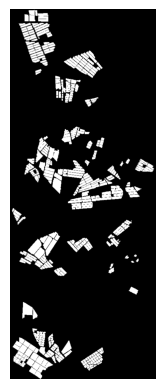

In [50]:
display_tiff_file (os.path.join(directory, 'mask_3763_reclass_bin.tif'))

## Clip the tiff files

Use rasterio to clip both the mask_3763_reclass_bin.tif and the output_ndvi_rpgi_albedo.tif, created above, into blocks

In [51]:
# Clip and rescale label images
clip_raster_and_rescale(os.path.join(directory, 'mask_3763_reclass_bin.tif'), label_folder, Nrows, Ncols)

# Clip and rescale image bands acording to bigmin and bigmax
height, width = clip_raster_and_rescale(os.path.join(directory, 'output_ndvi_rpgi_albedo.tif'), image_folder, Nrows, Ncols)


Create Datablocks and Dataloaders

In [52]:
# Create DataBlock
items = get_items(image_folder)
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(image_folder, bs=8)

Extract and print, if necessary, the file names for the train and test datasets

In [53]:
# Extract file names of the training dataset
train_file_names = dls.train_ds.items
# Extract file names of the test dataset
test_file_names = dls.valid_ds.items
#print(train_file_names)
#print(test_file_names)

## Train the model

In [54]:
# Train the model
if not train_model:
    # Load the model to be used
    learn = load_learner(os.path.join(directory, model_name))
else:
    learn = unet_learner(dls, resnet34)
    learn.fine_tune(N_epochs)
    # Save the model according to the number of epochs used
    learn.export(os.path.join(directory, new_model_name))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


epoch,train_loss,valid_loss,time
0,0.419452,0.211943,00:10


epoch,train_loss,valid_loss,time
0,0.270701,0.181912,00:02
1,0.249268,0.180712,00:01
2,0.238918,0.149764,00:01
3,0.242980,0.152758,00:01
4,0.226091,0.156467,00:02
5,0.208143,0.599003,00:02
6,0.208132,0.149676,00:02
7,0.201180,0.147446,00:01
8,0.192261,0.147221,00:01
9,0.193344,0.164994,00:01


In [55]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
preds = learn.get_preds(dl=test_dl)
print(preds[0].shape, preds[1])

torch.Size([160, 2, 58, 57]) None


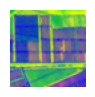

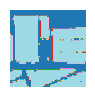

In [56]:
# Display one example of a prediction
sample_preds (preds, sample_idx=0)

In [57]:
# Save the predicted mask images (png) according to their row and column number
create_predited_mask(image_folder, learn, predicted_folder)

## Merge blocks - images, labels and predicted labels

In [58]:
# Put together all the blocks in label_folder
merge_blocks(label_folder,'labels', 'merged_labels.png', Nrows, Ncols, width, height)

In [59]:
# Put together all the blocks in image_folder
merge_blocks(image_folder,'images', 'merged_images.png', Nrows, Ncols, width, height)

In [60]:
# Put together all the blocks in predicted_folder
merge_blocks(predicted_folder, 'predicted', 'merged_predicted_labels.png', Nrows, Ncols, width, height)

### Display the merged png files

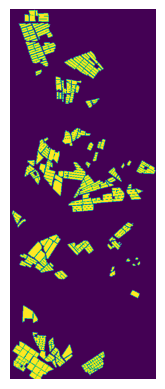

In [61]:
# Open the PNG image
image = Image.open(os.path.join(directory,'merged_labels.png'))

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

## Display and compare **Results**

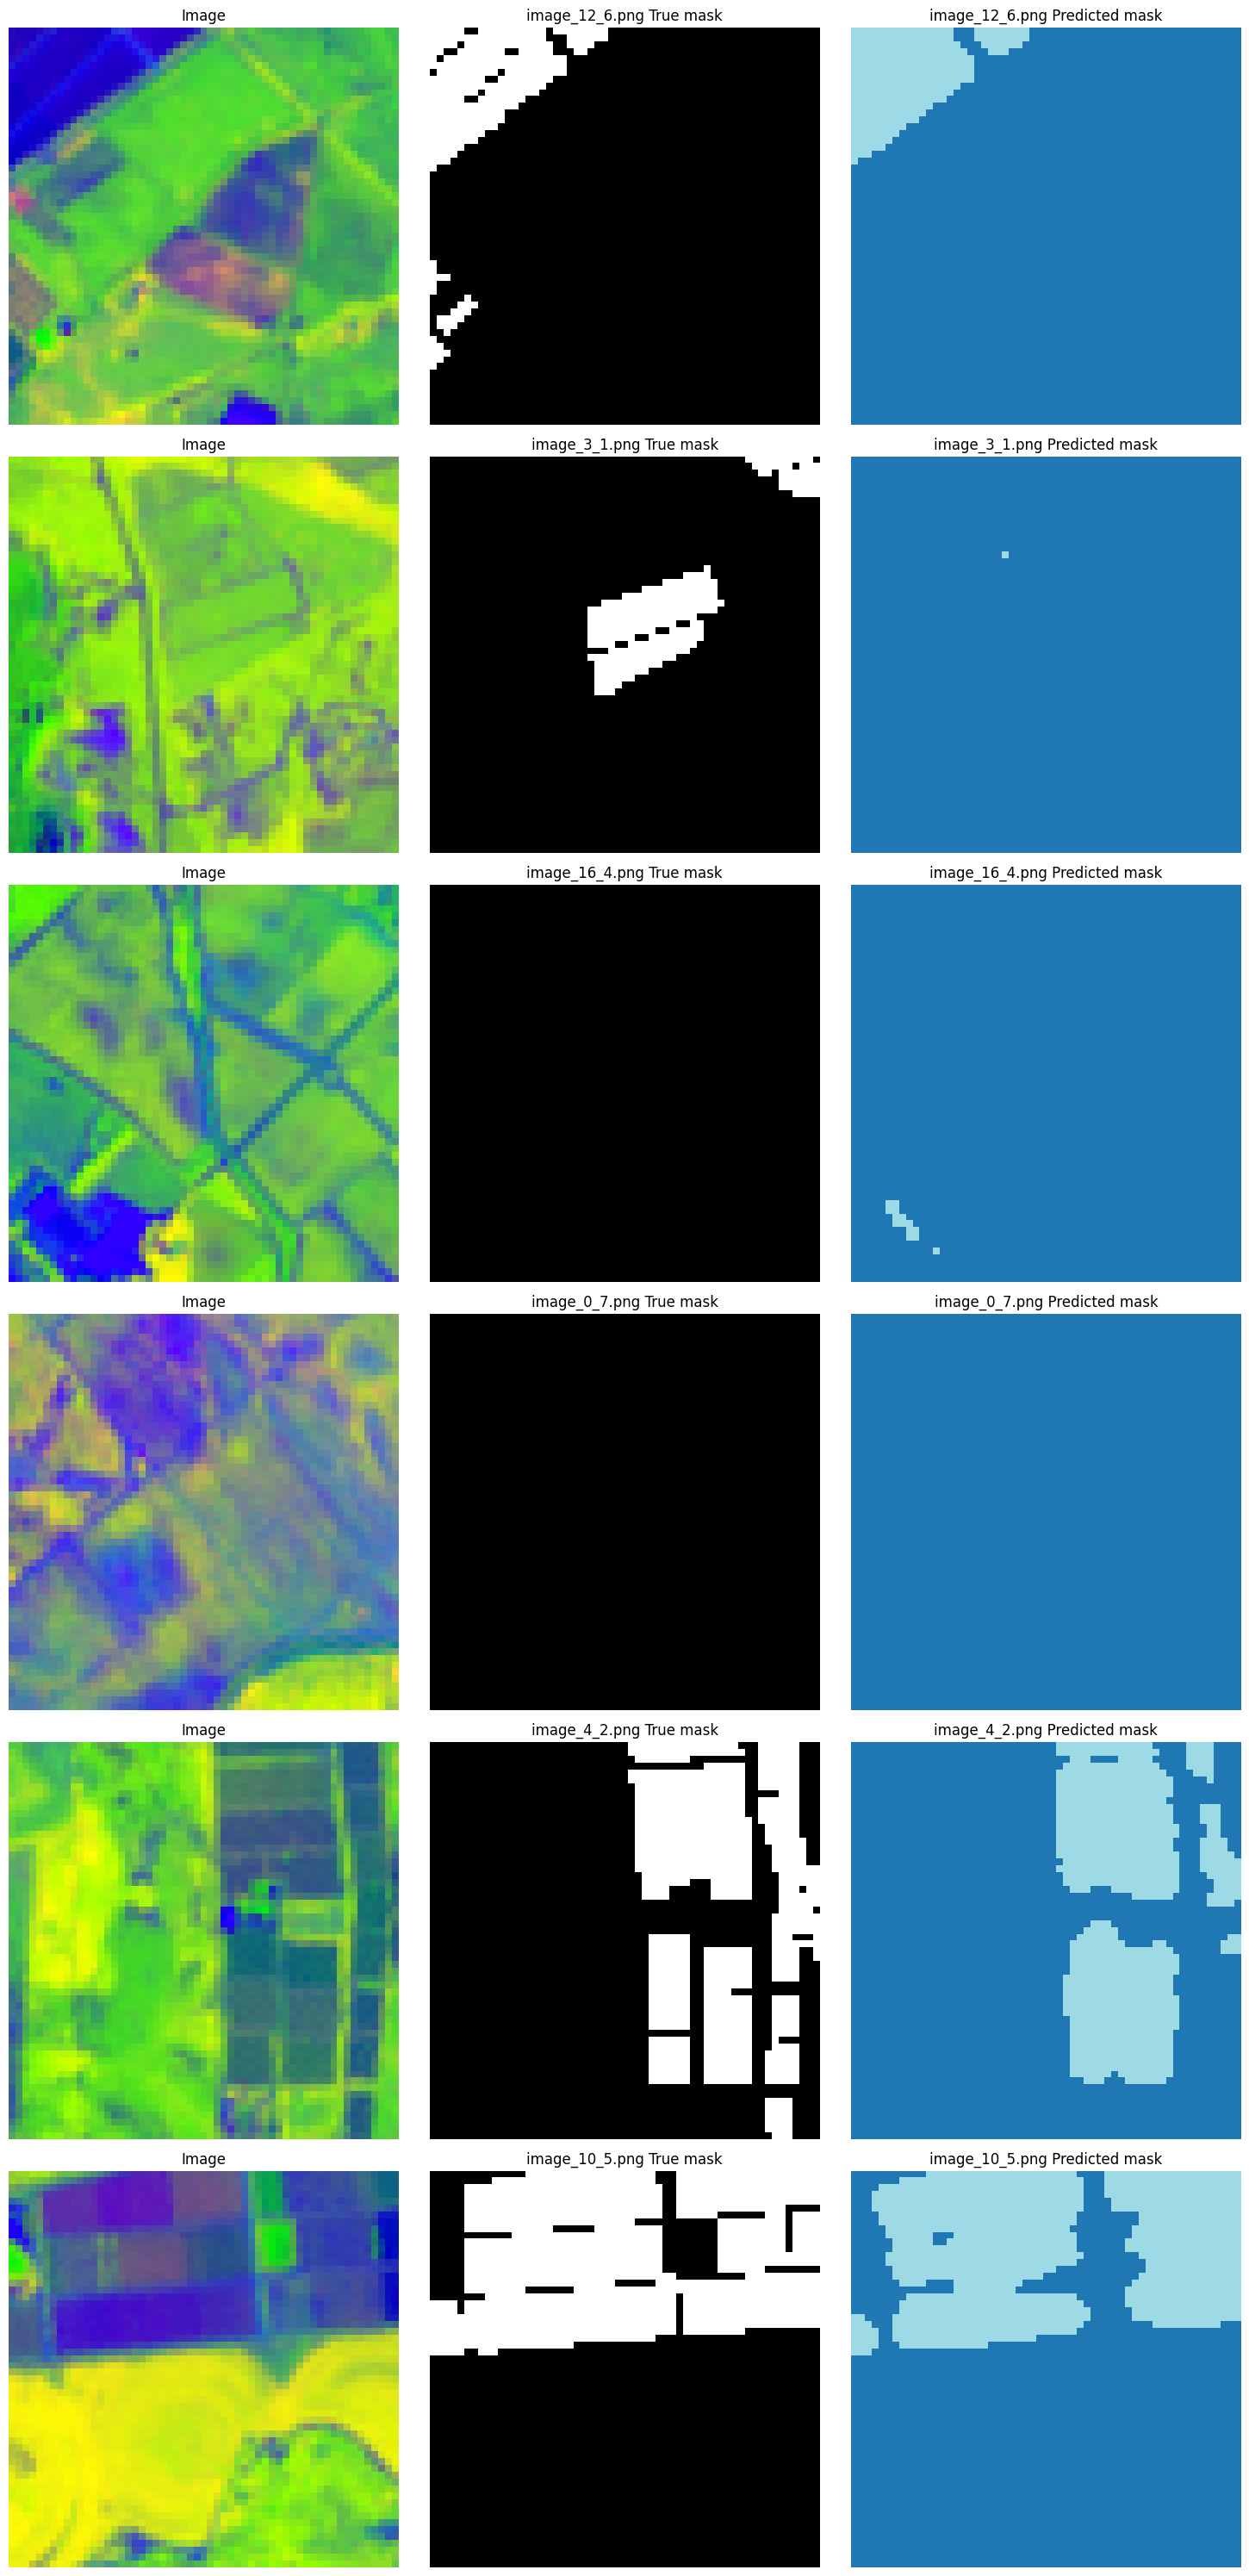

In [62]:
# Display images, ground-truth mask and the respective predicted mask
display_images(directory, image_folder, label_folder, predicted_folder, preds)

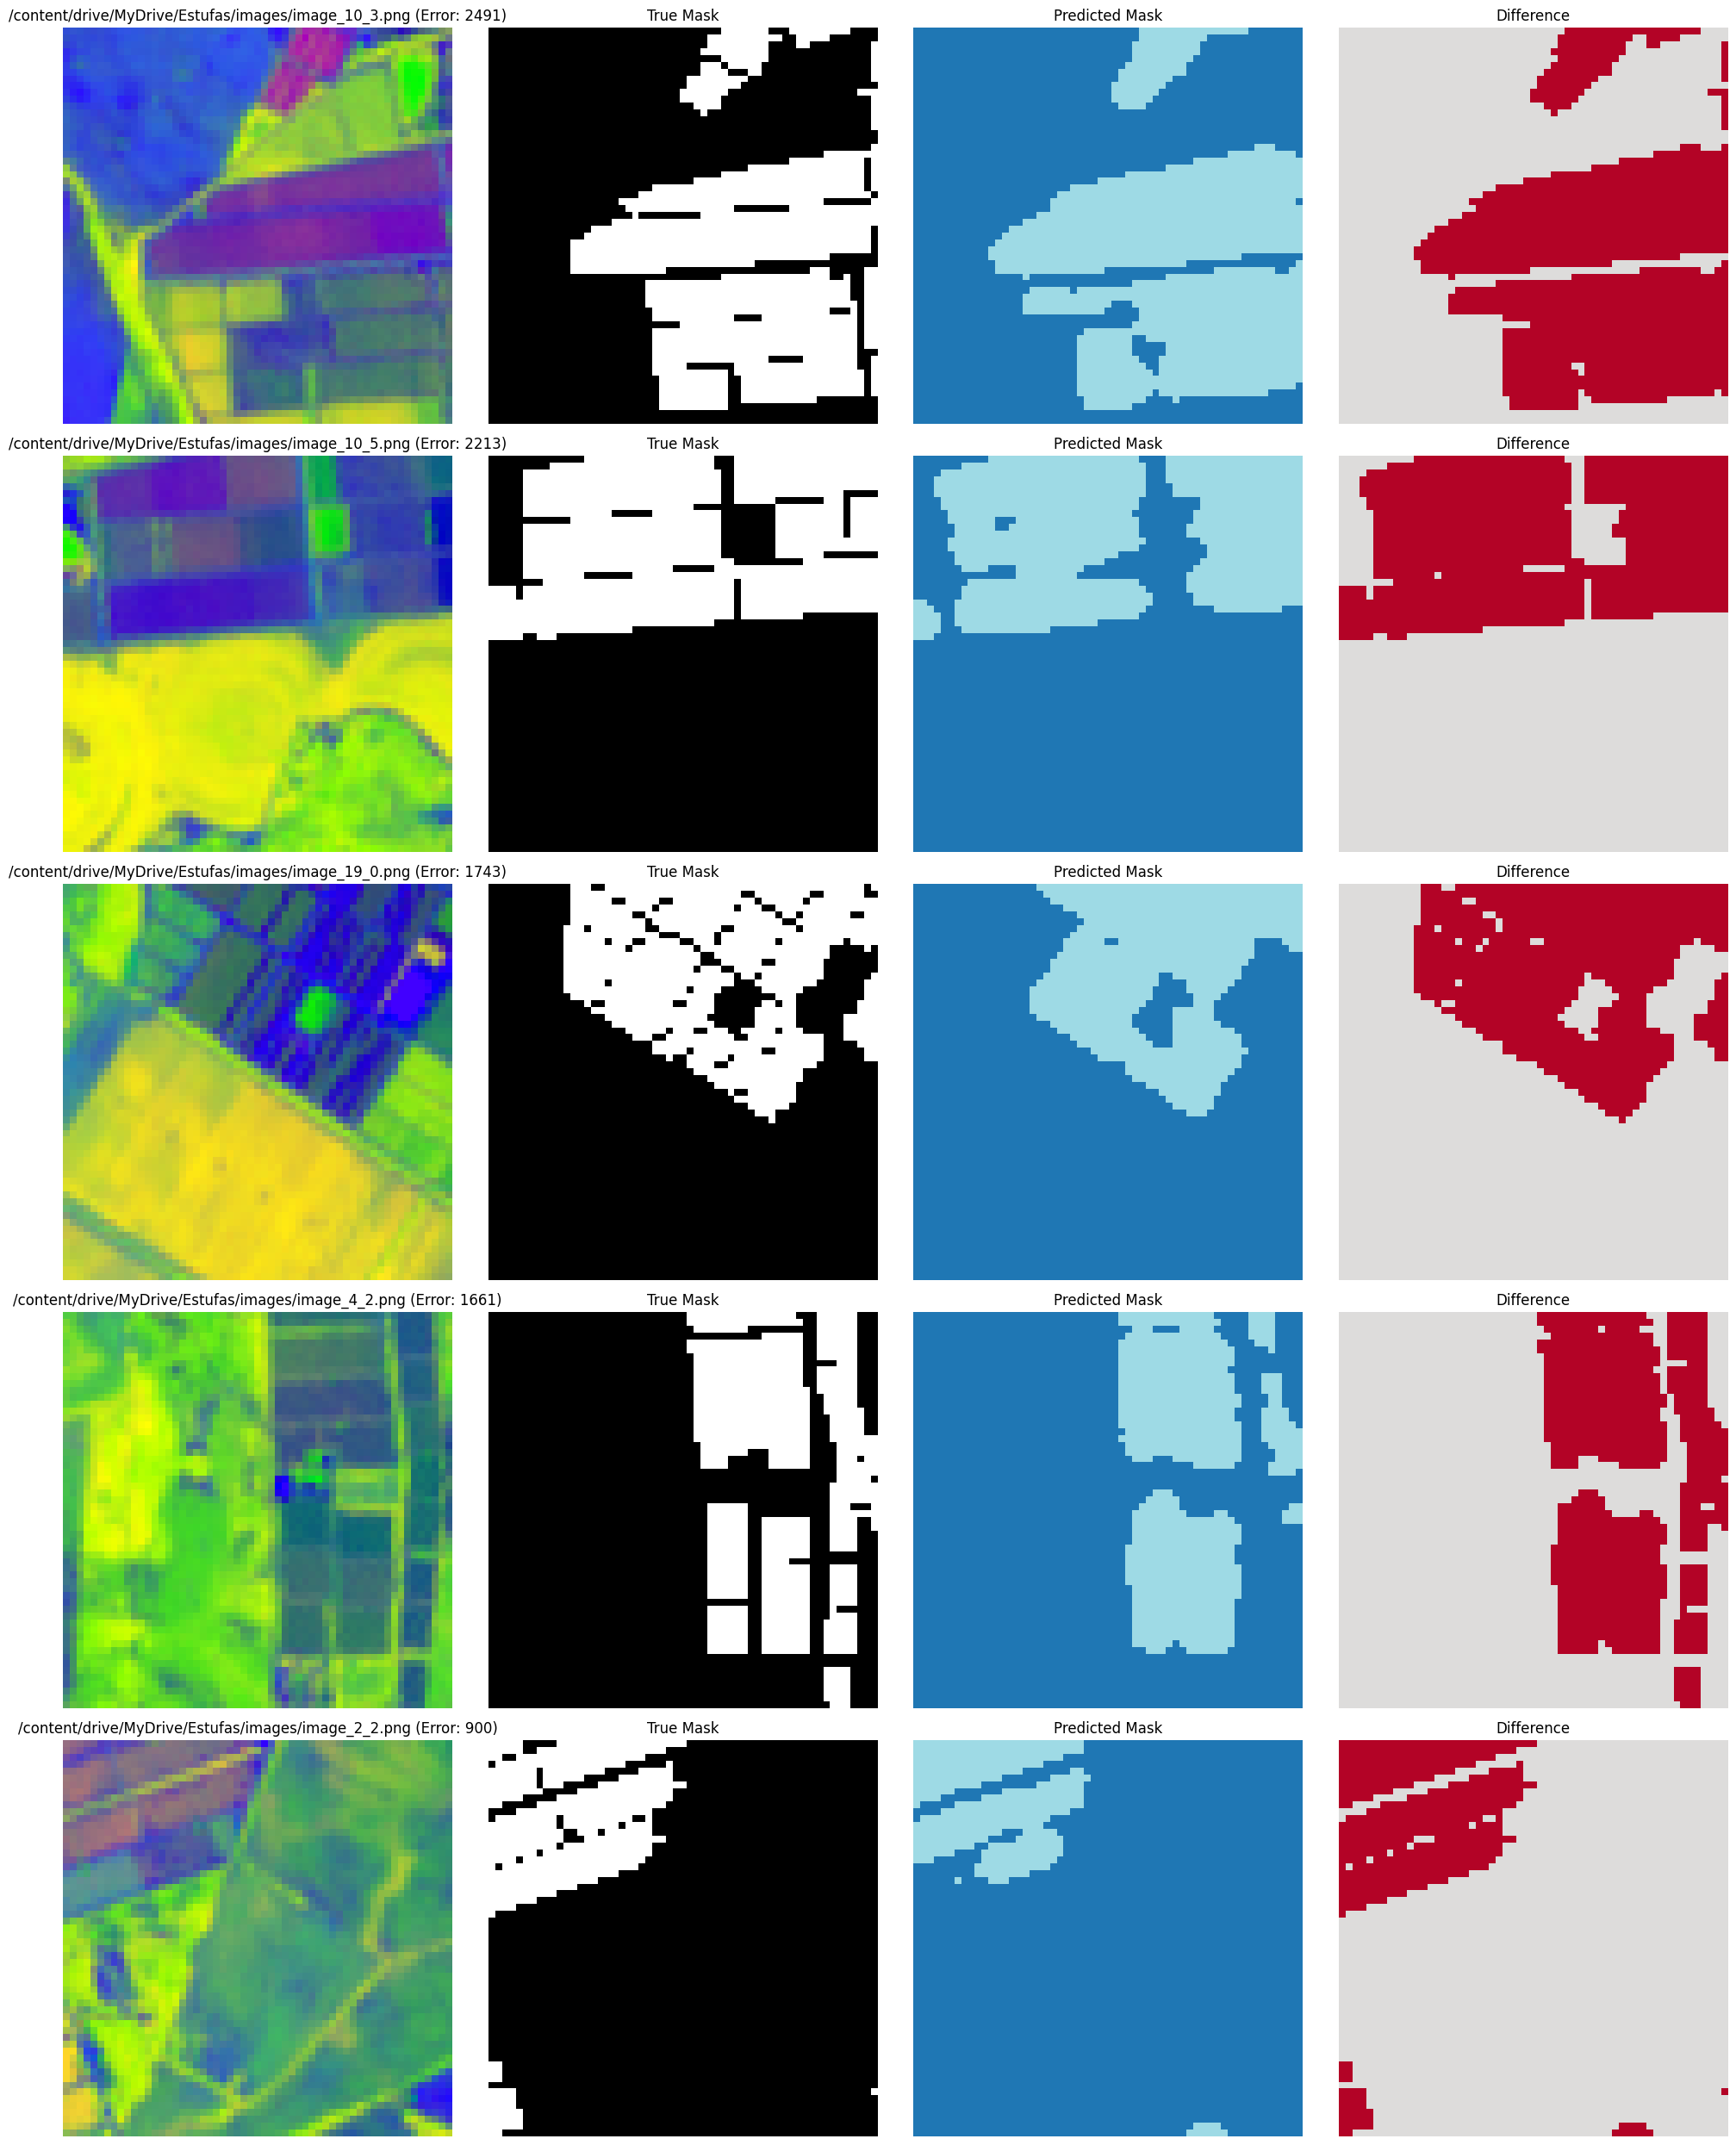

In [63]:
# Calculate and display images, ground-truth mask and the respective predicted mask, plus the pixel-wise error associated to each block
pixel_wise_errors(test_file_names, label_folder, predicted_folder, image_folder)

## Confusion Matrix calculation

In [64]:
# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Calculate the confusion matrix for the test set
true_masks_flat, predicted_masks_flat = true_and_pred_mask_to_1D_numpy(dls, preds)
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Test Set:")
print(conf_matrix)


Confusion Matrix for the Test Set:
[[97664  1353]
 [ 2290  4485]]


## Model's Accuracy

In [65]:
#Accuracy of the model
accuracy = model_accuracy(true_masks_flat, predicted_masks_flat)
print("Model Accuracy for the Test Set: {:.2f}%".format(accuracy * 100))

Model Accuracy for the Test Set: 96.56%


In [66]:
# Calculate and print the classification report
report = classification_report(true_masks_flat, predicted_masks_flat, target_names=target_names)
print("\nClassification Report for the Test Set:")
print(report)


Classification Report for the Test Set:
                precision    recall  f1-score   support

not greenhouse       0.98      0.99      0.98     99017
    greenhouse       0.77      0.66      0.71      6775

      accuracy                           0.97    105792
     macro avg       0.87      0.82      0.85    105792
  weighted avg       0.96      0.97      0.96    105792



Check the unique values in the created png image and, if needed, convert the value to obtain only 0 and 1

In [67]:
display_unique_values_and_datatype(os.path.join(directory, 'merged_predicted_labels.png'))

Data Type: uint8
Unique Values:
0
255
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
# replace pixel values from 255 to 1. Output file is a png with pixels 0 and 1
convert_values_png(os.path.join(directory, 'merged_predicted_labels.png'), os.path.join(directory, 'merged_predicted_labels_converted.png'), 255)

Image processing complete. Saved as /content/drive/MyDrive/Estufas/merged_predicted_labels_converted.png


In [69]:
display_unique_values_and_datatype(os.path.join(directory, 'merged_predicted_labels_converted.png'))

Data Type: uint8
Unique Values:
0
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Comission and omission errors

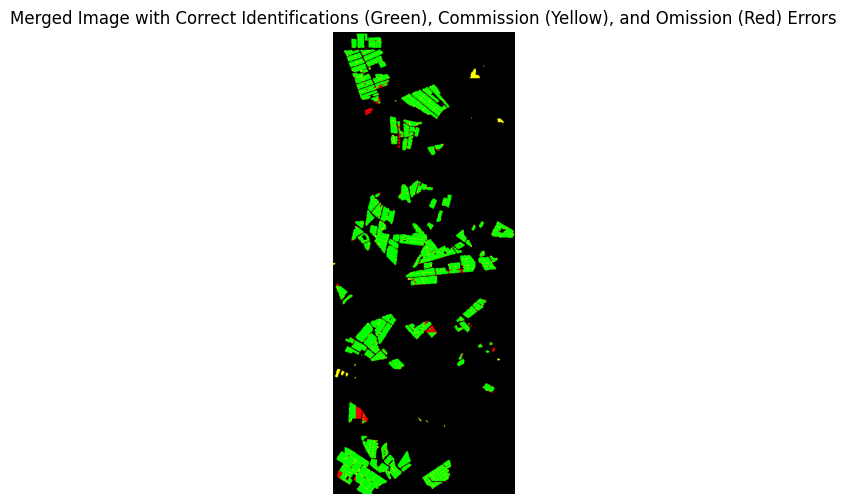

In [70]:
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_converted.png'), directory, 'comission_omission.png')

## K-fold cross validation

In [ ]:
kfold_cross_val = kfold_validation(5, 5)

In [ ]:
convert_values_png(os.path.join(directory, 'merged_predicted_labels_fold1.png'), os.path.join(directory, 'merged_predicted_labels_fold1_converted.png'), 255)
convert_values_png(os.path.join(directory, 'merged_predicted_labels_fold2.png'), os.path.join(directory, 'merged_predicted_labels_fold2_converted.png'), 255)
convert_values_png(os.path.join(directory, 'merged_predicted_labels_fold3.png'), os.path.join(directory, 'merged_predicted_labels_fold3_converted.png'), 255)
convert_values_png(os.path.join(directory, 'merged_predicted_labels_fold4.png'), os.path.join(directory, 'merged_predicted_labels_fold4_converted.png'), 255)
convert_values_png(os.path.join(directory, 'merged_predicted_labels_fold5.png'), os.path.join(directory, 'merged_predicted_labels_fold5_converted.png'), 255)

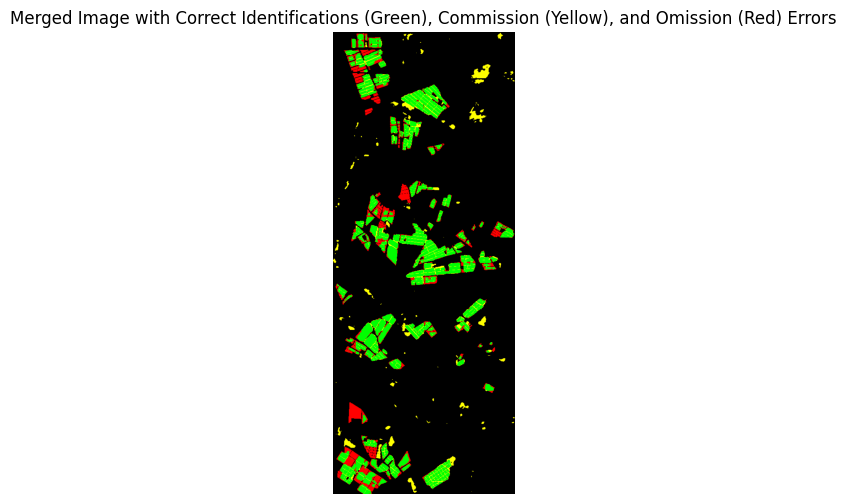

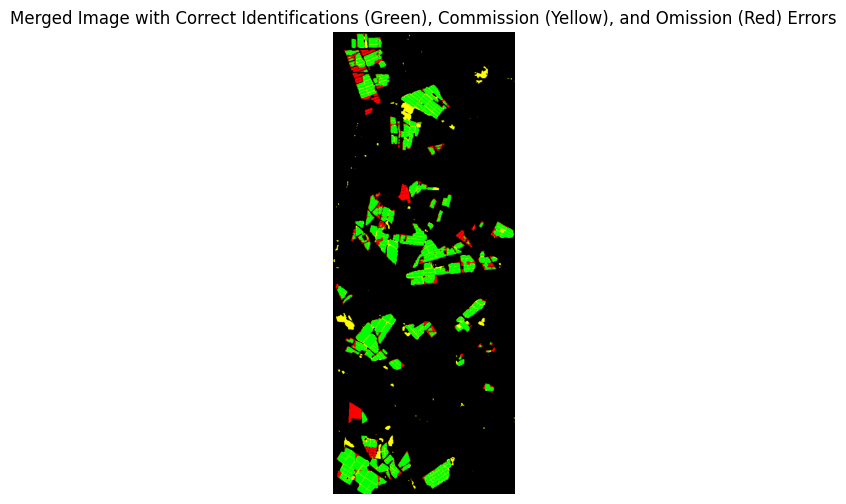

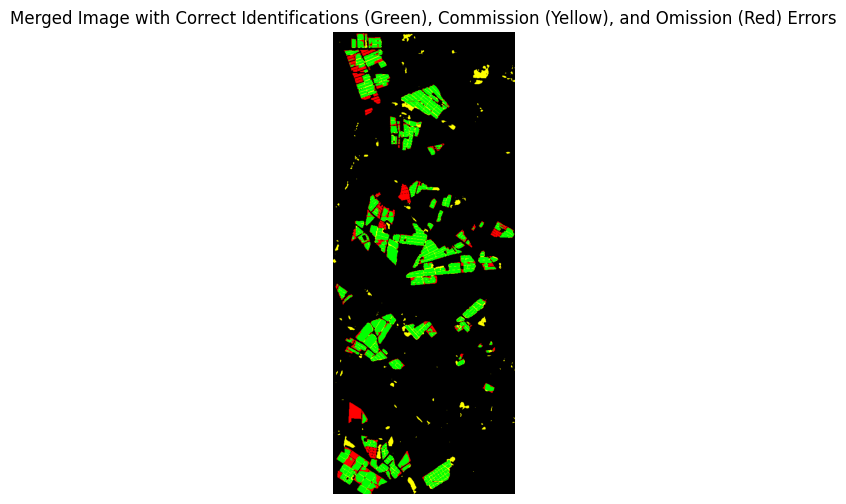

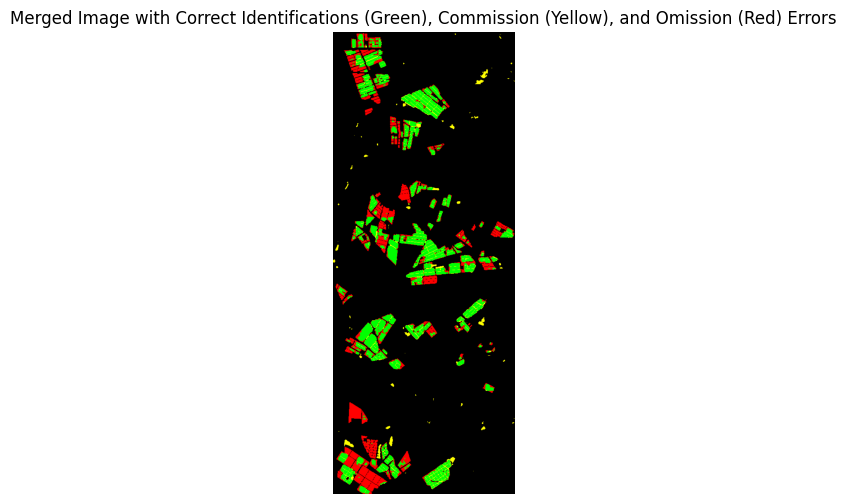

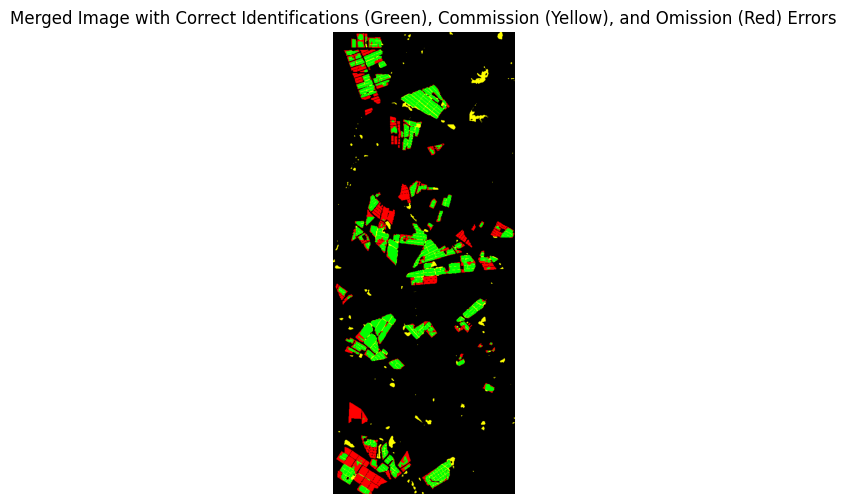

In [136]:
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_fold1_converted.png'), directory, 'comission_omission_fold1.png')
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_fold2_converted.png'), directory, 'comission_omission_fold2.png')
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_fold3_converted.png'), directory, 'comission_omission_fold3.png')
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_fold4_converted.png'), directory, 'comission_omission_fold4.png')
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'merged_predicted_labels_fold5_converted.png'), directory, 'comission_omission_fold5.png')

In [ ]:
vote_common_pixel = most_common_pixel()

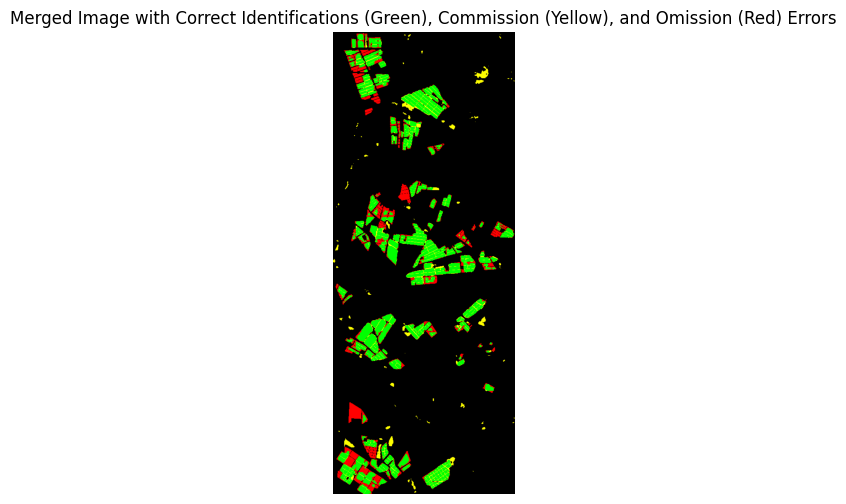

In [143]:
comission_omission_errors(os.path.join(directory, 'merged_labels.png'), os.path.join(directory, 'common_pixel.png'), directory, 'comission_omission_common_pixel.png')